In [2]:
import nibabel as nib
import os, glob
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim
from torch.nn import MSELoss
import monai
import torch.nn.functional as F
import monai.networks.nets as nets
from monai.config import print_config
from monai.data import DataLoader, Dataset, CacheDataset, PatchDataset
from monai.inferers import SliceInferer
from monai.utils import set_determinism, first
from monai.transforms import(
    Compose,
    Lambdad,
    LoadImaged,
    EnsureChannelFirstd,
    MapTransform,
    SqueezeDimd, 
    RandSpatialCropSamplesd, 
    ScaleIntensityRangePercentilesd, 
    Resized,
    CropForegroundd, 
    CenterSpatialCropd, 
    RandZoomd
)
from monai.losses import DiceCELoss
# print_config()
from datetime import date
today = str(date.today()).replace('-','').replace(' ', '')
gpu_device = torch.device(f'cuda:{0}')

/home/kharroubi/anaconda3/envs/project/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class Options():
    def __init__(self):
        # I/O
        self.where_is_ProstaTS = '/home/kharroubi/Dataset/Multireader_NIFTI_crop'
        self.Masks_uncertainty = '/home/kharroubi/Dataset/Masks_Agreement_Maps'
        self.RESULTS_DIR = '/home/kharroubi/2Decoders'
        self.RESULTS_Testing_DIR = '/home/kharroubi/2_Decoder_Unet_Testing'
        self.EXPERIMENT_PREFIX='SEGTEST'
        self.weights_dir=os.path.join('/home/kharroubi/EXPERIMENTS/SEG', self.EXPERIMENT_PREFIX)
        
        # model parameters
        self.in_channels = 4  # Adjust according to your input image channel dimensions
        self.out_channels = 4  # Adjust according to your output image channel dimensions
        self.num_res_units_G = 9
        self.ROI_SIZE=(128,128,32)
        # training parameters
        self.num_epochs=30
        self.N_train = 60  # number of training samples
        self.learning_rate = 2e-4
        self.lambda_DiceCE=1  
        self.lambda_multi_loss = 1  # Weight for multi-class segmentation loss 
        self.lambda_conf= 1
        self.lambda_CE = 1
        self.val_every=5  #  check val every ? step

opt=Options()

In [4]:
from monai.transforms import MapTransform, Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityRangePercentilesd, Resized
from monai.data import CacheDataset, DataLoader
import numpy as np
from monai.data.meta_tensor import MetaTensor
import torch
# Custom transform to map specific values
class MapUncMaskValues(MapTransform):
    def __init__(self, keys):
        super().__init__(keys)
        self.mapping = {0.0000: 0, 0.49803925: 1, 1.0000: 2}

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            if key in d:
                mask = d[key]
                if isinstance(mask, MetaTensor):
                    # Convert MetaTensor to numpy array for processing
                    mask_array = mask.cpu().numpy() if torch.is_tensor(mask) else mask.numpy()
                    conditions = [mask_array == k for k in self.mapping.keys()]
                    choices = list(self.mapping.values())
                    mapped_array = np.select(conditions, choices, default=mask_array)
                    # Convert numpy array back to MetaTensor
                    d[key] = MetaTensor(torch.tensor(mapped_array), meta=mask.meta)
                else:
                    raise TypeError(f"Expected MetaTensor for {key}, but got {type(mask)}")
        return d

In [5]:
#2 DEcoder taking the encoder output as input
import torch
import torch.nn as nn
import monai.networks.nets as nets

from monai.networks.blocks.unetr_block import UnetrBasicBlock,UnetrUpBlock
import torch.nn as nn
import torch
from monai.networks.blocks.dynunet_block import UnetOutBlock



class DualUnet_decoder(nn.Module):
    """
    UNETR based on: "Hatamizadeh et al.,
    UNETR: Transformers for 3D Medical Image Segmentation <https://arxiv.org/abs/2103.10504>"
    """

    def __init__(
       self,
       spatial_dims,
       in_channels,
       features,
       norm_name,
       res_block,
       kernel_sizes,
       stride,
       criterion_segmentation,
       criterion_confidence,
       lambda_seg=0.3,
       lambda_conf=0.7,
       out_channels1=1,
       out_channels2=3,
       multipath=1
    ):
    
        super(DualUnet_decoder,self).__init__()

        self.encoder= BasicUnetEnc(spatial_dims,in_channels,features,
                            norm_name,
                            res_block,
                            kernel_sizes,
                            stride
                            ) 
        self.decoder1= CNN_decoder(spatial_dims,
                        multipath,
                        features,
                        norm_name,
                        res_block,
                        kernel_sizes,
                        stride
                        )
        self.decoder2= CNN_decoder(spatial_dims,
                        multipath,
                        features,
                        norm_name,
                        res_block,
                        kernel_sizes,
                        stride
                        )
        self.out1 = UnetOutBlock(spatial_dims=spatial_dims, in_channels=features[0], out_channels=out_channels1)
        self.out2 = UnetOutBlock(spatial_dims=spatial_dims, in_channels=features[0], out_channels=out_channels2)
        
        # Loss functions and lambda parameters
        self.criterion_segmentation = criterion_segmentation
        self.criterion_confidence = criterion_confidence
        self.lambda_seg = lambda_seg
        self.lambda_conf = lambda_conf

    def forward(self, x):
        z=self.encoder(x)
        y1=self.out1(self.decoder1(z)[-1])
        y2=self.out2(self.decoder2(z)[-1])
         # Apply activations
        y1_seg = torch.sigmoid(y1)  # Sigmoid activation for segmentation  
        return y1_seg, y2
        
    
    def compute_losses(self, seg_pred, seg_true, conf_pred, conf_true):
        seg_loss = self.criterion_segmentation(seg_pred, seg_true)
        conf_loss = self.criterion_confidence(conf_pred, conf_true)
        total_loss = self.lambda_seg * seg_loss + self.lambda_conf * conf_loss
        return total_loss, seg_loss, conf_loss   


class BasicUnetEnc(nn.ModuleList):

    def __init__(
       self,
       spatial_dims,
       in_channels,
       features,
       norm_name,
       res_block,
       kernel_sizes,
       stride
    ):
        super(BasicUnetEnc,self).__init__()
        self.encoderList=nn.ModuleList()
        features=tuple([in_channels])+features

        for i in range(len(features)-1):             
            encoder= UnetrBasicBlock(
                    spatial_dims=spatial_dims,
                    in_channels=features[i],
                    out_channels=features[i+1],
                    kernel_size=tuple(kernel_sizes[i]),
                    stride=tuple(stride[i]),
                    norm_name=norm_name,
                    res_block=res_block
                    )
            self.encoderList.append(encoder)


    def forward(self, x):
        y=[]
        for j in range(len(self.encoderList)):
            x = self.encoderList[j](x)
            y.append(x)
        return y 

"""
DECODER
"""
class CNN_decoder(nn.ModuleList):

    def __init__(
       self,
       spatial_dims,
       multipath,
       features,
       norm_name,
       res_block,
       kernel_sizes,
       stride,
    ):
        super(CNN_decoder,self).__init__()
        self.decoderList=nn.ModuleList()

        for i in range(len(features)-1):
            decoder = UnetrUpBlock(
                    spatial_dims=spatial_dims,
                    in_channels=features[-i-1]* multipath,
                    out_channels=features[-i-2] * multipath,
                    kernel_size=tuple(kernel_sizes[-i-1]),
                    upsample_kernel_size= tuple(stride[-i-1]),
                    norm_name=norm_name,
                    res_block=res_block,
                    )
            self.decoderList.append(decoder)
            
    def forward(self, x):
        y=[]
        x1=x[-1]
        for j in range(len(self.decoderList)):
            x1 = self.decoderList[j](x1,x[-j-2])
            y.append(x1)
        return y   


if __name__ == "__main__":
    criterion_segmentation = DiceCELoss()
    criterion_confidence = DiceCELoss(to_onehot_y=True, softmax=True)
    model= DualUnet_decoder(spatial_dims=3,
                            in_channels=4,
                            features=(32, 64, 128, 256, 320, 512),
                            norm_name='instance',
                            res_block=True,
                            kernel_sizes=[[1, 3, 3], [1, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3]],
                            stride=[[1,1,1],[2, 2, 1], [2, 2, 1], [2, 2, 2], [2, 2, 2], [2, 2, 2]],
                            criterion_segmentation = DiceCELoss(),
                            criterion_confidence = DiceCELoss(to_onehot_y=True, softmax=True),
                            )
    x=torch.rand((1,4,128,128,32))
    y1_seg, y2=model(x)
    print(y1_seg.shape)
    print(y2.shape)
learning_rate = opt.learning_rate  # Adjust the learning rate as needed
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)

torch.Size([1, 1, 128, 128, 32])
torch.Size([1, 3, 128, 128, 32])


In [6]:
PIDs_ALL = [i.split('/')[-1] for i in glob.glob(os.path.join(opt.where_is_ProstaTS,'ANON*'))]
np.random.seed(29100) 
np.random.shuffle(PIDs_ALL)
PIDs_test = PIDs_ALL[65:]
fnames_test = {seq: [os.path.join(opt.where_is_ProstaTS, PID, PID + f"_{seq}.nii.gz") for PID in PIDs_test] for seq in ['T2', 'B2000', 'Perf', 'ADC']}
fnames_test.update({'MASK_VB': [os.path.join(opt.where_is_ProstaTS, PID, 'mask_Prostate_VB.nii.gz') for PID in PIDs_test],
                     'Unc_MASK': [os.path.join(opt.Masks_uncertainty, PID + '_uncertainty_map.nii.gz') for PID in PIDs_test]})

test_dic = [{"T2": img1, "B2000": img2, "Perf": img3, "ADC": img4, "MASK_VB": img5, "Unc_MASK": img6 }
           for img1, img2, img3, img4, img5, img6 in zip(*[fnames_test[seq] for seq in ['T2', 'B2000', 'Perf', 'ADC', 'MASK_VB', 'Unc_MASK']])]

test_transforms = Compose(
    [
        LoadImaged(keys=["T2","B2000","Perf","ADC", "MASK_VB", "Unc_MASK"], image_only=False),
        EnsureChannelFirstd(keys=["T2","B2000","Perf","ADC", "MASK_VB", "Unc_MASK"]),
        ScaleIntensityRangePercentilesd(keys=["T2", "B2000", "Perf", "ADC"], lower=1, upper=99, b_min=-1,b_max=1, clip=True),
        Resized(keys=["T2","B2000","Perf","ADC"], spatial_size=opt.ROI_SIZE, mode="trilinear"),
        Resized(keys=["MASK_VB", "Unc_MASK"], spatial_size=opt.ROI_SIZE, mode="nearest-exact"),
        MapUncMaskValues(keys=["Unc_MASK"])
    ]
)

BATCH_SIZE = 1
NUM_WORKERS = 1
test_ds_fullsize = CacheDataset(test_dic, test_transforms, num_workers=NUM_WORKERS)
test_loader_fullsize = DataLoader(test_ds_fullsize, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

Loading dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 5/5 [00:01<00:00,  2.68it/s]


Loading dataset: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]


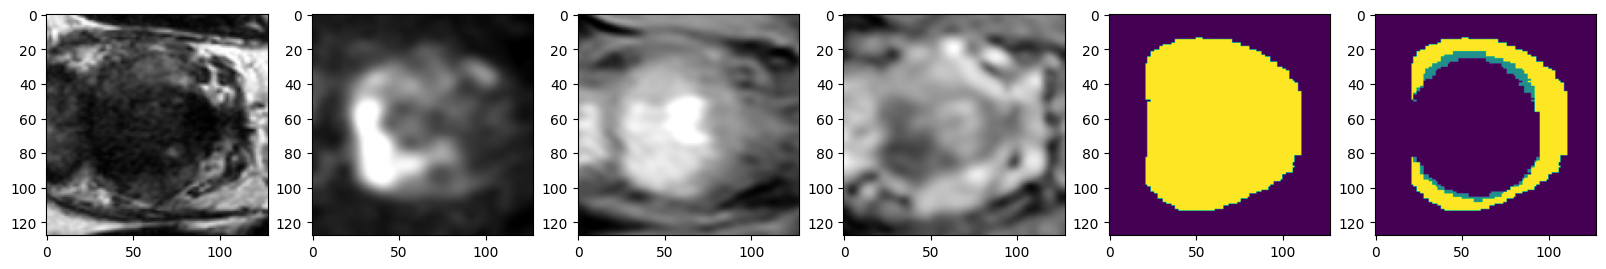

In [7]:
test_ds_fullsize = CacheDataset(test_dic, test_transforms, num_workers=NUM_WORKERS)
test_loader_fullsize = DataLoader(test_ds_fullsize, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
check_data = first(test_loader_fullsize)
# Ensure that all keys are present in check_data
expected_keys = ["T2", "B2000", "Perf", "ADC", "MASK_VB", "Unc_MASK"]
for key in expected_keys:
    if key not in check_data:
        raise ValueError(f"Key {key} not found in check_data.")

plt.figure(figsize=(20,6)) 
plt.subplot(1,6,1)                     
plt.imshow(check_data["T2"][0,0,:,:,16], cmap='gray')
plt.subplot(1,6,2)                     
plt.imshow(check_data["B2000"][0,0,:,:,16], cmap='gray')
plt.subplot(1,6,3)                     
plt.imshow(check_data["Perf"][0,0,:,:,16], cmap='gray')
plt.subplot(1,6,4)                     
plt.imshow(check_data["ADC"][0,0,:,:,16], cmap='gray')
plt.subplot(1,6,5)
plt.imshow(check_data["MASK_VB"][0,0,:,:,16])
plt.subplot(1,6,6)
plt.imshow(check_data["Unc_MASK"][0,0,:,:,16])

In [8]:
# Load the trained model weights
model_path = '/home/kharroubi/EXPERIMENTS/SEG/SEGTEST/SEGTEST_e0025.h34'  
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [9]:
import torch
import numpy as np
from tqdm import tqdm

model.eval()
predictions_with_data = []

# Initialize variables to store testing losses (unused in the code snippet)
test_seg_loss = 0.0
test_conf_loss = 0.0

for epoch in np.arange(1, opt.num_epochs + 1):
    loop = tqdm(test_loader_fullsize)
    loop.set_description(f"Epoch [{epoch}/{opt.num_epochs}]")

    for real_test in loop:
        # Prepare input and ground truth tensors
        real_A_test = torch.cat([real_test[key].to(gpu_device) for key in ["T2", "B2000", "Perf", "ADC"]], dim=1)
        real_B_seg_test = real_test["MASK_VB"].to(gpu_device)
        real_B_unc_test = real_test["Unc_MASK"].to(gpu_device)

        # Ensure the model is on the correct device
        model = model.to(gpu_device)

        # Forward pass
        seg_out_test, consensus_out_test = model(real_A_test)

        # Move predictions and data back to CPU and convert to numpy arrays
        real_A_cpu = real_A_test.cpu().numpy()  # Corrected variable name
        real_B_cpu = real_B_seg_test.cpu().numpy()
        seg_out_test_cpu = seg_out_test.detach().cpu().numpy()  # Corrected variable name
        consensus_out_test_cpu = consensus_out_test.detach().cpu().numpy()  # Corrected variable name

        # Append a tuple containing the image, mask, and prediction to the list
        predictions_with_data.append((real_A_cpu, real_B_cpu, seg_out_test_cpu, consensus_out_test_cpu))

Epoch [30/30]: 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]


In [10]:
import os
import nibabel as nib
import torch
import numpy as np
from monai.inferers import SlidingWindowInferer
from monai.transforms import AsDiscrete, Compose

# Define post-processing transforms
post_transforms = Compose([
    AsDiscrete(threshold=0.1, keys=['SEG_PRED', 'CONF_PRED'])
])

# Set ROI size for Sliding Window Inferer
ROI_SIZE = (128, 128, 32)

model.eval()
for i, val_data in enumerate(test_loader_fullsize):
    # Iterate over each modality
    for modality in ["T2", "B2000", "Perf", "ADC"]:
        # Extract the filename for the current modality
        fname = val_data[f"{modality}_meta_dict"]["filename_or_obj"][0]
        print('Processing', fname)
        nii = nib.load(fname)

        val_images = torch.cat([val_data[key] for key in ["T2", "B2000", "Perf", "ADC"]], dim=1).to(gpu_device)

        inferer = SlidingWindowInferer(
            roi_size=ROI_SIZE, 
            overlap=0.75, 
            mode='gaussian',
            sw_batch_size=1
        )

        # Ensure model is on GPU
        model.to(gpu_device)

        # Get segmentation and confidence predictions from the model
        with torch.no_grad():
            y1_seg, y2 = inferer(val_images, model)
        
        # Apply AsDiscrete directly to segmentation and confidence predictions
        y1_seg = AsDiscrete(threshold=0.1)(y1_seg)
        y2 = AsDiscrete(threshold=0.1)(y2)

        # Convert segmentation and confidence predictions to numpy arrays
        y1_seg_np = y1_seg.detach().cpu().numpy()
        y2_np = y2.detach().cpu().numpy()

        # Check shapes for debugging
        print('SEG_PRED shape:', y1_seg_np.shape)
        print('CONF_PRED shape:', y2_np.shape)

        # Save the segmentation output as Nifti image
        nii_out_seg = nib.Nifti1Image(y1_seg_np.squeeze(), None, nii.header)
        fname_out_seg = os.path.join(opt.RESULTS_Testing_DIR, os.path.basename(fname).split('.nii.gz')[0] + '_seg_pred.nii.gz')
        nib.save(nii_out_seg, fname_out_seg)

        # Save the confidence output as Nifti image
        nii_out_conf = nib.Nifti1Image(y2_np.squeeze(), None, nii.header)
        fname_out_conf = os.path.join(opt.RESULTS_Testing_DIR, os.path.basename(fname).split('.nii.gz')[0] + '_conf_pred.nii.gz')
        nib.save(nii_out_conf, fname_out_conf)

Processing /home/kharroubi/Dataset/Multireader_NIFTI_crop/ANON30628/ANON30628_T2.nii.gz
SEG_PRED shape: (1, 1, 128, 128, 32)
CONF_PRED shape: (1, 3, 128, 128, 32)
Processing /home/kharroubi/Dataset/Multireader_NIFTI_crop/ANON30628/ANON30628_B2000.nii.gz
SEG_PRED shape: (1, 1, 128, 128, 32)
CONF_PRED shape: (1, 3, 128, 128, 32)
Processing /home/kharroubi/Dataset/Multireader_NIFTI_crop/ANON30628/ANON30628_Perf.nii.gz
SEG_PRED shape: (1, 1, 128, 128, 32)
CONF_PRED shape: (1, 3, 128, 128, 32)
Processing /home/kharroubi/Dataset/Multireader_NIFTI_crop/ANON30628/ANON30628_ADC.nii.gz
SEG_PRED shape: (1, 1, 128, 128, 32)
CONF_PRED shape: (1, 3, 128, 128, 32)
Processing /home/kharroubi/Dataset/Multireader_NIFTI_crop/ANON24110/ANON24110_T2.nii.gz
SEG_PRED shape: (1, 1, 128, 128, 32)
CONF_PRED shape: (1, 3, 128, 128, 32)
Processing /home/kharroubi/Dataset/Multireader_NIFTI_crop/ANON24110/ANON24110_B2000.nii.gz
SEG_PRED shape: (1, 1, 128, 128, 32)
CONF_PRED shape: (1, 3, 128, 128, 32)
Processing /h

In [12]:
import os
import glob
import numpy as np
import nibabel as nib
from skimage.transform import resize  # Ensure this import for resizing
from medpy.metric.binary import dc as dice  # Ensure this import for Dice coefficient



# After processing validation data, calculate Dice scores for segmentation and confidence maps
fnames_seg_pred = sorted(glob.glob(os.path.join(opt.RESULTS_DIR, '*_seg_pred.nii.gz')))
fnames_conf_pred = sorted(glob.glob(os.path.join(opt.RESULTS_DIR, '*_conf_pred.nii.gz')))
PIDs = list(set(os.path.basename(fname).split('_')[0] for fname in fnames_seg_pred))  # Unique PIDs
fnames_MASK = [os.path.join('/home/kharroubi/Dataset/Multireader_NIFTI_crop', PID, 'mask_Prostate_VB.nii.gz') for PID in PIDs]
#fnames_MASK = [os.path.join('/home/kharroubi/Dataset/Combined_Masks', f'combined_mask_{PID}.nii.gz') for PID in PIDs]
fnames_unc_MASK = [os.path.join(opt.Masks_uncertainty, PID + '_uncertainty_map.nii.gz') for PID in PIDs]

SCORES_seg = np.zeros(len(PIDs))
SCORES_conf = np.zeros(len(PIDs))

for i, (PID, fname_MASK, fname_seg_pred, fname_conf_pred, fname_unc_MASK) in enumerate(zip(PIDs, fnames_MASK, fnames_seg_pred, fnames_conf_pred, fnames_unc_MASK)):
    try:
        MASK = nib.load(fname_MASK).get_fdata()
        SEG_PRED = nib.load(fname_seg_pred).get_fdata()
        UNC_MASK = nib.load(fname_unc_MASK).get_fdata()
        CONF_PRED = nib.load(fname_conf_pred).get_fdata()

        # Resize the predicted mask to match the shape of the ground truth mask
        SEG_PRED_resized = resize(SEG_PRED, MASK.shape, order=0, preserve_range=True)

        # Resize the predicted confidence map to match the spatial dimensions of the uncertainty mask
        CONF_PRED_resized = CONF_PRED[..., 0]  # Assuming only one channel
        CONF_PRED_resized = resize(CONF_PRED_resized, UNC_MASK.shape, order=0, preserve_range=True)

        # Calculate the Dice score for segmentation and confidence maps
        SCORES_seg[i] = dice(MASK, SEG_PRED_resized)
        SCORES_conf[i] = dice(UNC_MASK, CONF_PRED_resized)

        print(f'{PID}  Seg: {SCORES_seg[i]:.3f}  Conf: {SCORES_conf[i]:.3f}')
    except Exception as e:
        print(f"Error calculating scores for {PID}: {e}")

# Print the average Dice scores
print(f'AVG dice Segmentation: {np.mean(SCORES_seg):.3f} ± {np.std(SCORES_seg):.3f}')
print(f'AVG dice Confidence: {np.mean(SCORES_conf):.3f} ± {np.std(SCORES_conf):.3f}')


ANON19504  Seg: 0.892  Conf: 0.090
ANON24110  Seg: 0.875  Conf: 0.125
ANON69112  Seg: 0.855  Conf: 0.138
ANON27849  Seg: 0.911  Conf: 0.123
ANON78084  Seg: 0.881  Conf: 0.093
ANON30919  Seg: 0.877  Conf: 0.123
ANON79358  Seg: 0.873  Conf: 0.091
ANON13338  Seg: 0.837  Conf: 0.053
ANON30628  Seg: 0.847  Conf: 0.080
ANON70828  Seg: 0.838  Conf: 0.136
AVG dice Segmentation: 0.869 ± 0.023
AVG dice Confidence: 0.105 ± 0.027
